# NBA Point Spread Regressor Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

Autosaving every 60 seconds


### Utils functions

In [3]:
def filter_from(items, cond):
    return list(filter(cond, items)) 

In [4]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [5]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [19]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [6]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [7]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [8]:
def plot_results(experiment_name, results, figsize=(10,6)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    #     a = sns.pointplot(data=results_df,
    #               kind="point", x="season_test", y="rmse", hue="model"
    #               )
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="mae", hue="model", style="model",
        markers=True, dashes=False
    )
    a.set_title(
        f"{experiment_name}-mae")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [10]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='mae', filter_val=None):
    second_metric = 'rmse' if metric == 'mae' else 'mae'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model == filter_val)
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [11]:
season_games = sg.load_season_games_dataset()

## Dataset


In [26]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [12]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [13]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 405)
0
(9461, 405)


## Experiments

### Setup

In [14]:
exp_prefix = "reg_"
## exp_group_name = "reg_experiments"
exp_group_name = "reg_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_POINT_SPREAD"
exp_X_columns = model_config.X_REG_COLS_BEST_BORUTA
exp_y_columns = model_config.Y_REG_COL

models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [124]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [125]:
# instantiate random forest
from collections import defaultdict

## RandomForest
model = models[4][1]

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 200, random_state = 0)
list_selected_features = []
for train_idx, test_idx in folds[:]:
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(exp_X_columns)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

In [126]:
f_df = dict_to_list(folds_selected_features)

In [141]:
f_df.sort_values(by=[1, 0], ascending=False)
#f_df[f_df[1] > 2]
final_selected_features = list(f_df[0].unique())
sorted(final_selected_features)
final_selected_features

,0,1
4,HOME_PLUS_MINUS_MEAN,7
3,HOME_PLUS_MINUS_L10,7
2,HOME_FT_PCT,7
1,HOME_FG3_PCT,7
7,PLUS_MINUS_MEAN_HOME,3
15,HOME_PLUS_MINUS_ML10,3
11,W_L_CUM_HOME,2
17,PTS_ML10_HOME,2
8,PTS_MEAN_HOME,2
6,HOME_FG_PCT_MEAN,2


['BLK_L10_AWAY',
 'BLK_MEAN_AWAY',
 'BLK_MEAN_HOME',
 'FG_PCT_MEAN_HOME',
 'FG_PCT_ML10_HOME',
 'FT_PCT_L10_AWAY',
 'FT_PCT_ML10_HOME',
 'HOME_FG3_PCT',
 'HOME_FG_PCT_MEAN',
 'HOME_FT_PCT',
 'HOME_PF_ML10',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'PF_ML10_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_HOME',
 'PTS_ML10_HOME',
 'STL_L10_HOME',
 'STL_MEAN_AWAY',
 'STL_MEAN_HOME',
 'W_L_CUM_HOME']

['FT_PCT_L10_AWAY',
 'HOME_FG3_PCT',
 'HOME_FT_PCT',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'PF_ML10_AWAY',
 'HOME_FG_PCT_MEAN',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_HOME',
 'STL_MEAN_AWAY',
 'STL_MEAN_HOME',
 'W_L_CUM_HOME',
 'FG_PCT_MEAN_HOME',
 'FT_PCT_ML10_HOME',
 'HOME_PF_ML10',
 'HOME_PLUS_MINUS_ML10',
 'BLK_MEAN_HOME',
 'PTS_ML10_HOME',
 'BLK_L10_AWAY',
 'BLK_MEAN_AWAY',
 'STL_L10_HOME',
 'FG_PCT_ML10_HOME']

In [130]:
f_df.sort_values(by=[1, 0], ascending=False)
#best_boruta = list_selected_features[3]
#sorted(best_boruta)
#best_boruta

,0,1
4,HOME_PLUS_MINUS_MEAN,7
3,HOME_PLUS_MINUS_L10,7
2,HOME_FT_PCT,7
1,HOME_FG3_PCT,7
7,PLUS_MINUS_MEAN_HOME,3
15,HOME_PLUS_MINUS_ML10,3
11,W_L_CUM_HOME,2
17,PTS_ML10_HOME,2
8,PTS_MEAN_HOME,2
6,HOME_FG_PCT_MEAN,2


#### Test best features

In [132]:
#[x for x in exp_X_columns if x not in final_selected_features]
X_boruta = df_sscv[final_selected_features]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name, metric='mae')

Running experiment reg_2_seasons_boruta
Done


KeyError: "['precision_std', 'precision_mean'] not in index"

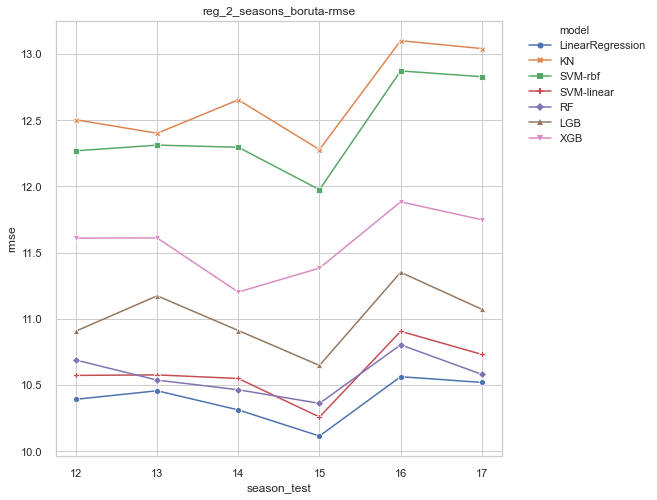

In [133]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

#### Test specific best feature set

In [134]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]

    experiment_name = f"{exp_prefix}2_seasons_boruta_specific_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))
    #print_prettier_exp_results(experiment_name, metric='mae')

Running experiment reg_2_seasons_boruta_specific_0
Done
Running experiment reg_2_seasons_boruta_specific_1
Done
Running experiment reg_2_seasons_boruta_specific_2
Done
Running experiment reg_2_seasons_boruta_specific_3
Done
Running experiment reg_2_seasons_boruta_specific_4
Done
Running experiment reg_2_seasons_boruta_specific_5
Done
Running experiment reg_2_seasons_boruta_specific_6
Done


#### Test custom best feature set

In [ ]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name, metric='mae')

### Experiment using 1 season

In [16]:
experiment_name = f"{exp_prefix}1_season"

In [17]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_1_season
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
2,reg_1_season,SVM,9.701766,0.248245,12.352453,0.322304
0,reg_1_season,LR,9.708537,0.236181,12.345849,0.324448
1,reg_1_season,KNN,9.906372,0.267774,12.631599,0.327252
3,reg_1_season,RF,10.172602,0.275392,12.950640,0.338954
4,reg_1_season,LGB,11.026313,0.298285,13.965188,0.381818
5,reg_1_season,XGB,11.399370,0.231851,14.442258,0.262853


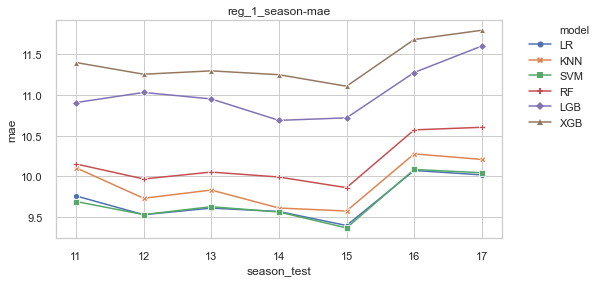

In [18]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [19]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment using StandardScaler

In [20]:
experiment_name = f"{exp_prefix}scaled_data"

In [21]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_scaled_data
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
8,reg_scaled_data,SVM,9.697497,0.248880,12.348898,0.325574
6,reg_scaled_data,LR,9.708537,0.236181,12.345849,0.324448
7,reg_scaled_data,KNN,9.918753,0.257424,12.596790,0.324897
9,reg_scaled_data,RF,10.173119,0.273867,12.949551,0.339289
10,reg_scaled_data,LGB,11.028666,0.271239,13.967897,0.343318
11,reg_scaled_data,XGB,11.403905,0.233589,14.449809,0.270923


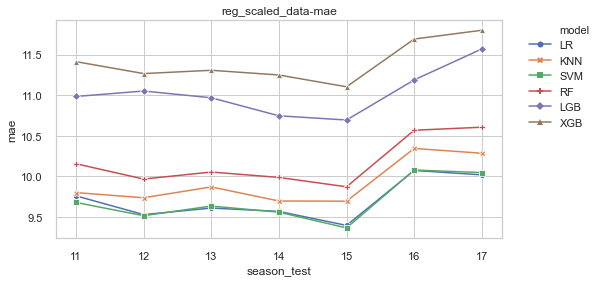

In [22]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


In [23]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment using MinMaxScaler

In [24]:
experiment_name = f"{exp_prefix}minmax_data"

In [25]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_minmax_data
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
14,reg_minmax_data,SVM,9.700779,0.233200,12.341002,0.317594
12,reg_minmax_data,LR,9.708537,0.236181,12.345849,0.324448
13,reg_minmax_data,KNN,9.920674,0.275440,12.598936,0.340648
15,reg_minmax_data,RF,10.173431,0.276305,12.950861,0.340021
16,reg_minmax_data,LGB,11.011716,0.283574,13.949775,0.351973
17,reg_minmax_data,XGB,11.402612,0.235563,14.446303,0.272577


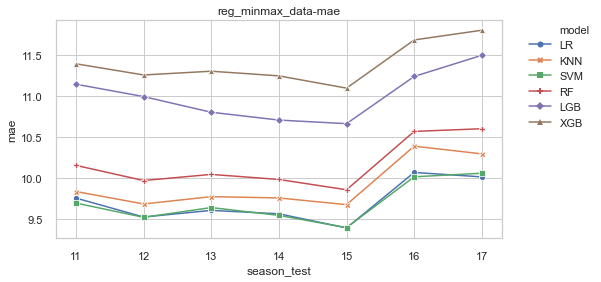

In [26]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [27]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment: train: 2s; test: 1s

In [28]:
experiment_name = f"{exp_prefix}2_seasons"

In [29]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment reg_2_seasons
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
18,reg_2_seasons,LR,9.691163,0.246533,12.332082,0.339228
20,reg_2_seasons,SVM,9.694799,0.267743,12.354811,0.345806
19,reg_2_seasons,KNN,9.872296,0.255617,12.616184,0.336962
21,reg_2_seasons,RF,10.061783,0.238989,12.807818,0.316661
22,reg_2_seasons,LGB,10.557379,0.234249,13.406109,0.312893
23,reg_2_seasons,XGB,11.050505,0.175196,14.015846,0.267697


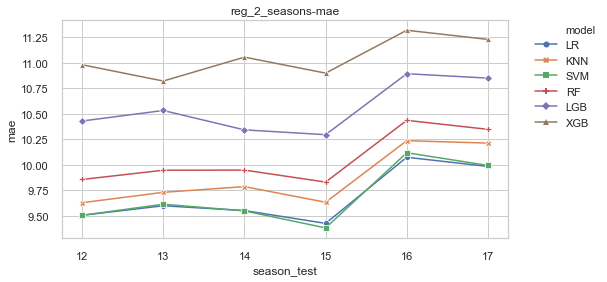

In [30]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [31]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11,2185,12,1209
1,11-12,2181,13,1213
2,12-13,2422,14,1213
3,13-14,2426,15,1213
4,14-15,2426,16,1214
5,15-16,2427,17,1214


### Experiment: train: 3s; test: 1s

In [32]:
experiment_name = f"{exp_prefix}3_seasons"

In [33]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3_seasons
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
24,reg_3_seasons,LR,9.715410,0.267527,12.349923,0.370741
26,reg_3_seasons,SVM,9.721795,0.278447,12.375117,0.368698
25,reg_3_seasons,KNN,9.886093,0.278791,12.620637,0.358092
27,reg_3_seasons,RF,10.081041,0.309874,12.800159,0.388977
28,reg_3_seasons,LGB,10.345399,0.263924,13.136103,0.314081
29,reg_3_seasons,XGB,11.210197,0.237797,14.166061,0.321328


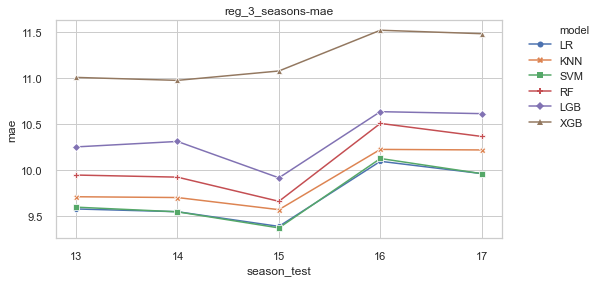

In [34]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [35]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11-12,3394,13,1213
1,11-12-13,3394,14,1213
2,12-13-14,3635,15,1213
3,13-14-15,3639,16,1214
4,14-15-16,3640,17,1214


### Experiment train: 2q ; test: 2q

In [36]:
experiment_name = f"{exp_prefix}2q_2q"

In [37]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
30,reg_2q_2q,LR,9.854929,0.438770,12.563554,0.537791
31,reg_2q_2q,KNN,9.915149,0.307408,12.569784,0.384275
32,reg_2q_2q,SVM,9.929100,0.437291,12.666207,0.533290
33,reg_2q_2q,RF,10.366468,0.332057,13.161170,0.456622
34,reg_2q_2q,LGB,11.151549,0.376768,14.077212,0.530484
35,reg_2q_2q,XGB,11.555386,0.540046,14.628320,0.723918


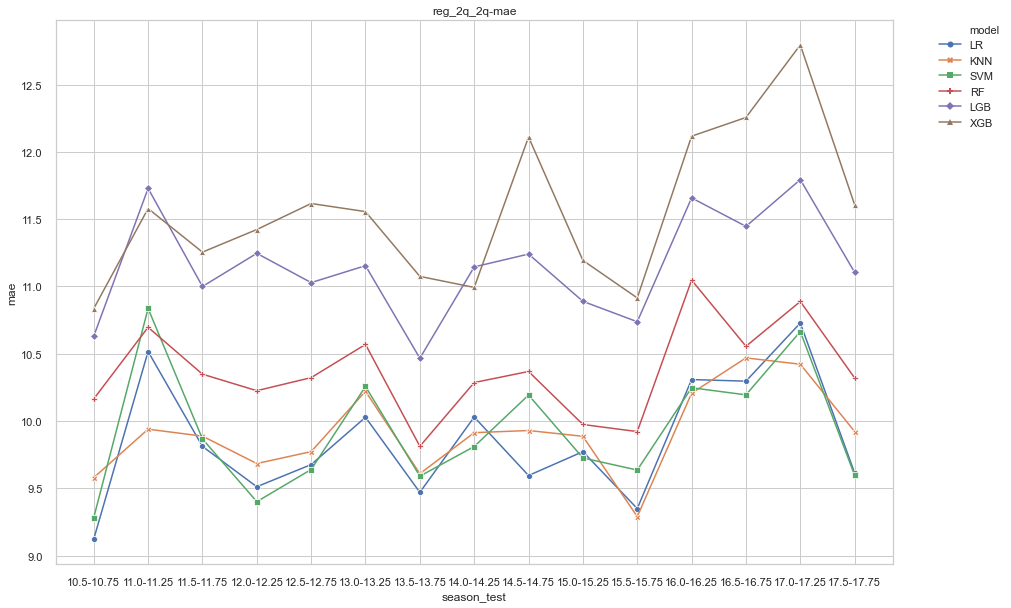

In [38]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [39]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25,606,10.5-10.75,607
1,10.5-10.75,607,11.0-11.25,486
2,11.0-11.25,486,11.5-11.75,486
3,11.5-11.75,486,12.0-12.25,604
4,12.0-12.25,604,12.5-12.75,605
5,12.5-12.75,605,13.0-13.25,606
6,13.0-13.25,606,13.5-13.75,607
7,13.5-13.75,607,14.0-14.25,606
8,14.0-14.25,606,14.5-14.75,607
9,14.5-14.75,607,15.0-15.25,606


### Experiment remove first 2q ;train: 2q ; test: 2q

In [40]:
experiment_name = f"{exp_prefix}2q_2q_r2q"

In [41]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_r2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
38,reg_2q_2q_r2q,SVM,9.589647,0.285459,12.268110,0.338251
36,reg_2q_2q_r2q,LR,9.619465,0.321776,12.292115,0.373537
37,reg_2q_2q_r2q,KNN,9.739308,0.346656,12.468391,0.376035
39,reg_2q_2q_r2q,RF,10.191971,0.346186,13.014066,0.399880
40,reg_2q_2q_r2q,LGB,10.970457,0.347481,13.985778,0.334799
41,reg_2q_2q_r2q,XGB,11.598705,0.410103,14.778253,0.481288


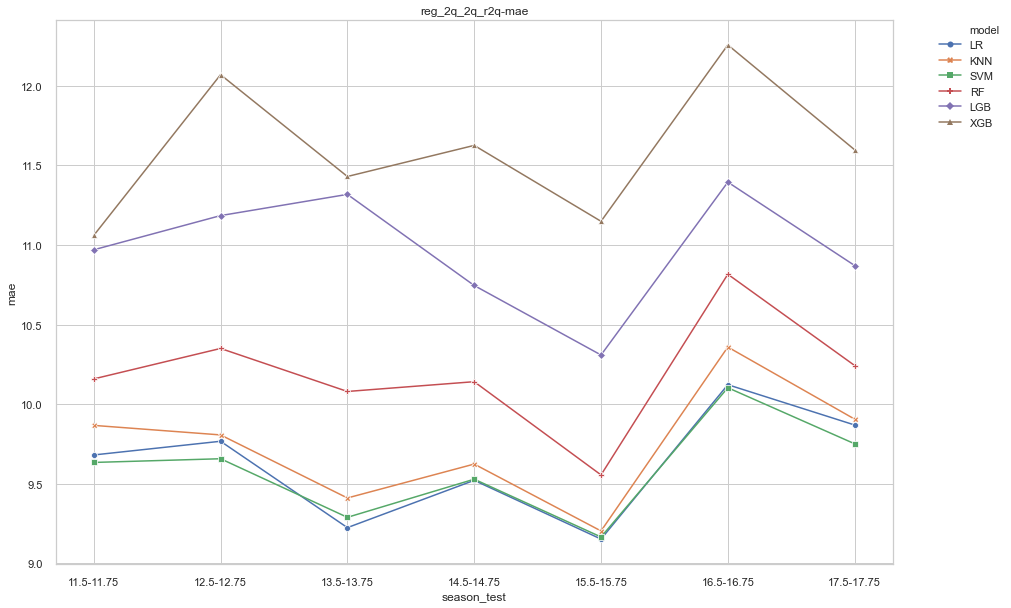

In [42]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [43]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75,607,11.5-11.75,486
1,11.5-11.75,486,12.5-12.75,605
2,12.5-12.75,605,13.5-13.75,607
3,13.5-13.75,607,14.5-14.75,607
4,14.5-14.75,607,15.5-15.75,607
5,15.5-15.75,607,16.5-16.75,607
6,16.5-16.75,607,17.5-17.75,607


### Experiment train: 3q ; test: 1q

In [44]:
experiment_name = f"{exp_prefix}3q_1q"

In [45]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
42,reg_3q_1q,LR,9.767526,0.566641,12.453310,0.666096
44,reg_3q_1q,SVM,9.774519,0.547039,12.453369,0.643492
43,reg_3q_1q,KNN,9.869927,0.475287,12.547279,0.561618
45,reg_3q_1q,RF,10.262573,0.525329,13.026092,0.642735
46,reg_3q_1q,LGB,11.174280,0.602684,14.067779,0.653389
47,reg_3q_1q,XGB,11.477950,0.600253,14.504362,0.844307


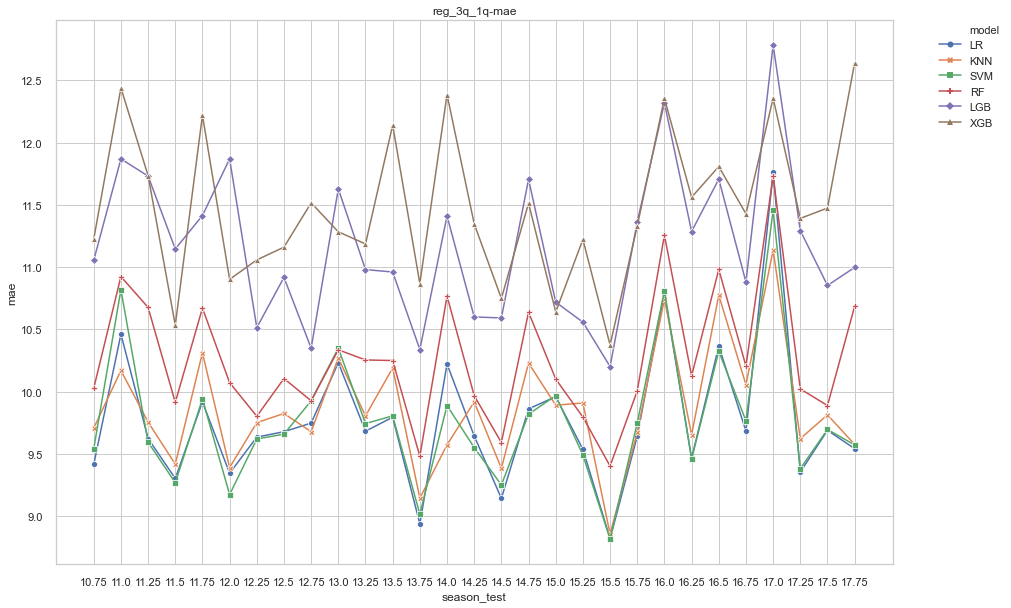

In [46]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [47]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,909,10.75,304
1,10.25-10.5-10.75,910,11.0,243
2,10.5-10.75-11.0,850,11.25,243
3,10.75-11.0-11.25,790,11.5,243
4,11.0-11.25-11.5,729,11.75,243
5,11.25-11.5-11.75,729,12.0,302
6,11.5-11.75-12.0,788,12.25,302
7,11.75-12.0-12.25,847,12.5,302
8,12.0-12.25-12.5,906,12.75,303
9,12.25-12.5-12.75,907,13.0,303


### Experiment train: 3q ; test: 1q ; skip: 3q

In [48]:
experiment_name = f"{exp_prefix}3q_1q_3s"

In [49]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_3s
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
48,reg_3q_1q_3s,LR,9.593731,0.290468,12.354174,0.363860
50,reg_3q_1q_3s,SVM,9.666488,0.280773,12.435643,0.354470
49,reg_3q_1q_3s,KNN,9.796975,0.359170,12.502358,0.420703
51,reg_3q_1q_3s,RF,10.205396,0.404541,13.028776,0.443226
52,reg_3q_1q_3s,LGB,11.013084,0.458159,13.978417,0.446052
53,reg_3q_1q_3s,XGB,11.593323,0.531684,14.735841,0.715654


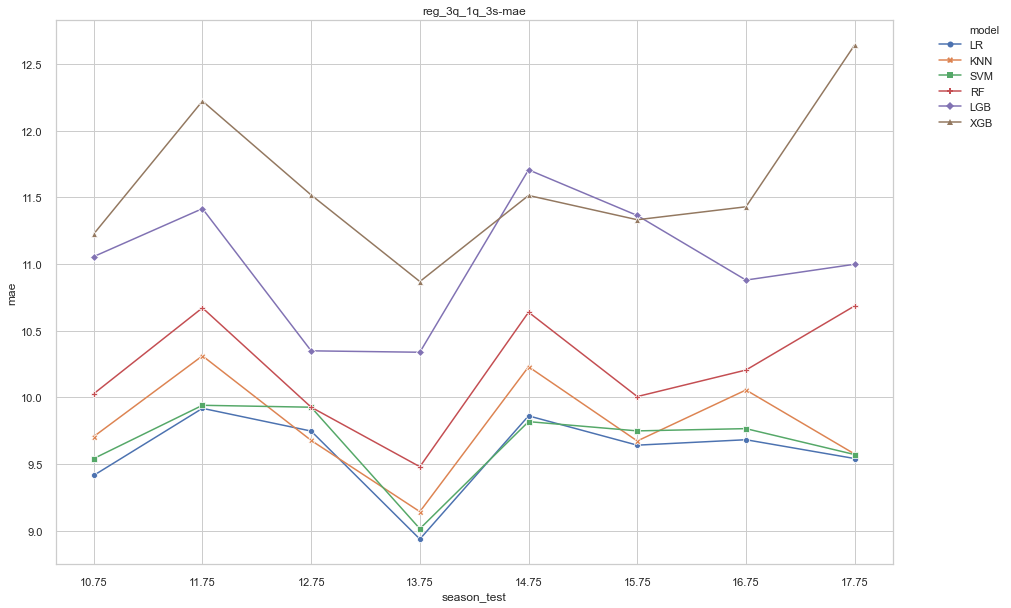

In [50]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [51]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,909,10.75,304
1,11.0-11.25-11.5,729,11.75,243
2,12.0-12.25-12.5,906,12.75,303
3,13.0-13.25-13.5,909,13.75,304
4,14.0-14.25-14.5,909,14.75,304
5,15.0-15.25-15.5,909,15.75,304
6,16.0-16.25-16.5,910,16.75,304
7,17.0-17.25-17.5,910,17.75,304


### Experiment train: 4q ; test: 2q

In [52]:
experiment_name = f"{exp_prefix}4q_2q"

In [53]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
56,reg_4q_2q,SVM,9.692999,0.316401,12.343705,0.376766
54,reg_4q_2q,LR,9.694890,0.309203,12.332711,0.374390
55,reg_4q_2q,KNN,9.893015,0.369676,12.620829,0.415521
57,reg_4q_2q,RF,10.155346,0.352945,12.905399,0.422177
58,reg_4q_2q,LGB,10.994143,0.352039,13.902822,0.428966
59,reg_4q_2q,XGB,11.339483,0.386988,14.348437,0.453917


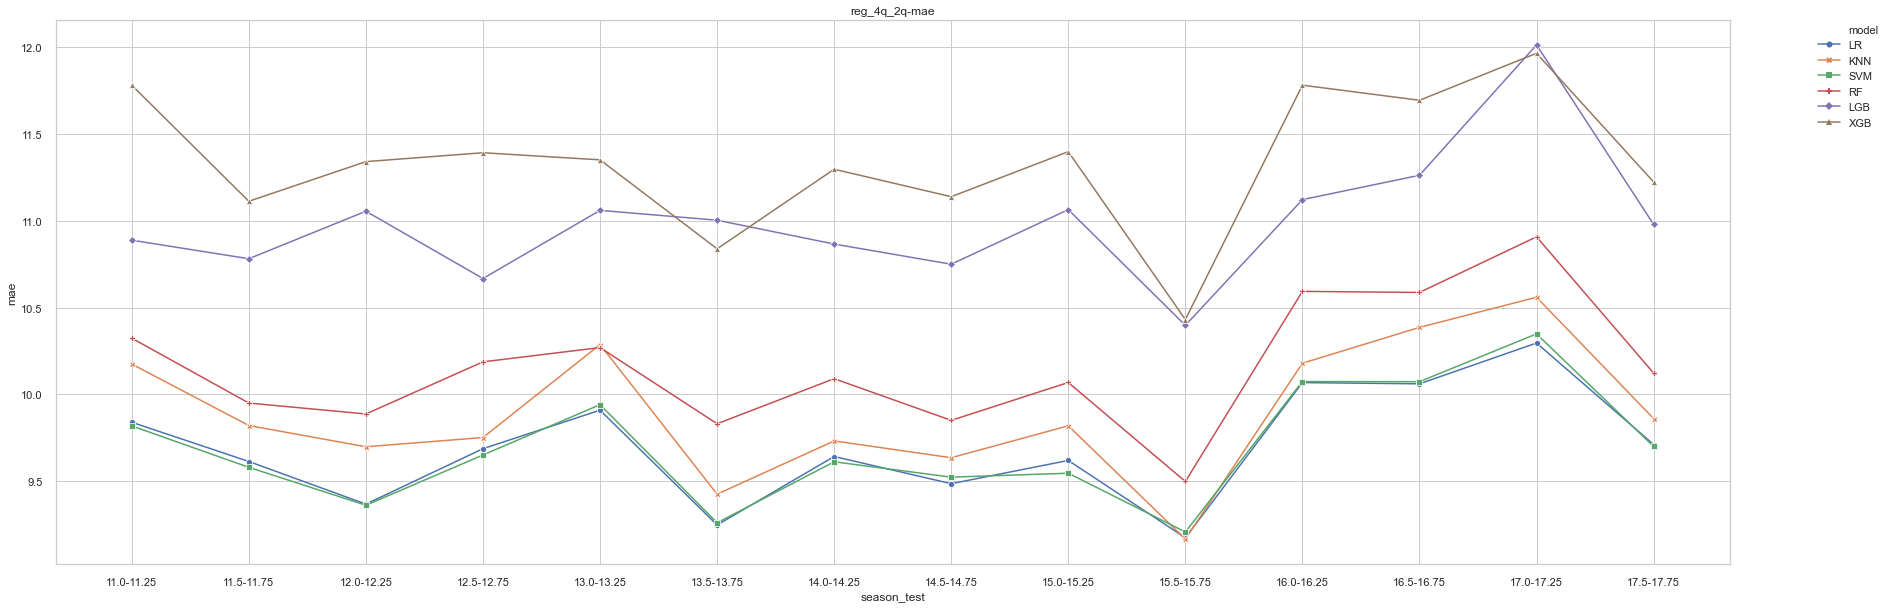

In [54]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

In [55]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5-10.75,1213,11.0-11.25,486
1,10.5-10.75-11.0-11.25,1093,11.5-11.75,486
2,11.0-11.25-11.5-11.75,972,12.0-12.25,604
3,11.5-11.75-12.0-12.25,1090,12.5-12.75,605
4,12.0-12.25-12.5-12.75,1209,13.0-13.25,606
5,12.5-12.75-13.0-13.25,1211,13.5-13.75,607
6,13.0-13.25-13.5-13.75,1213,14.0-14.25,606
7,13.5-13.75-14.0-14.25,1213,14.5-14.75,607
8,14.0-14.25-14.5-14.75,1213,15.0-15.25,606
9,14.5-14.75-15.0-15.25,1213,15.5-15.75,607


### Experiment remove first 2q ; train: 4q ; test: 2q

In [56]:
experiment_name = f"{exp_prefix}4q_2q_r2q"

In [57]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q_r2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
60,reg_4q_2q_r2q,LR,9.542236,0.308160,12.219452,0.367059
62,reg_4q_2q_r2q,SVM,9.544077,0.300203,12.231325,0.360551
61,reg_4q_2q_r2q,KNN,9.706900,0.349961,12.475350,0.380049
63,reg_4q_2q_r2q,RF,9.941100,0.398856,12.743328,0.472048
64,reg_4q_2q_r2q,LGB,10.692024,0.437117,13.646760,0.530764
65,reg_4q_2q_r2q,XGB,11.014295,0.246286,14.079177,0.436889


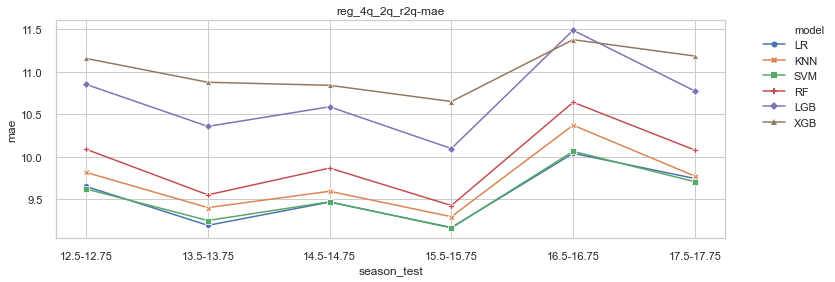

In [58]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(12,4))

In [59]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75-11.5-11.75,1093,12.5-12.75,605
1,11.5-11.75-12.5-12.75,1091,13.5-13.75,607
2,12.5-12.75-13.5-13.75,1212,14.5-14.75,607
3,13.5-13.75-14.5-14.75,1214,15.5-15.75,607
4,14.5-14.75-15.5-15.75,1214,16.5-16.75,607
5,15.5-15.75-16.5-16.75,1214,17.5-17.75,607


### Experiments comparison

In [60]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)
utils.serialize_object(f'result_totals_{exp_group_name}', results_total)

In [61]:
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = utils.deserialize_object(exp_group_name, [])
exp_df = get_results_df()

In [62]:
ba_df = exp_df[~exp_df.exp_name.isin(['reg_minmax_data', 'reg_scaled_data'])][['exp_name', 'model',
       'mae_mean', 'mae_std', 'rmse_mean', 'rmse_std']]

In [63]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [69]:
ba_df.sort_values(
    by=["mae_mean"]
    , ascending=True)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_4q_2q_r2q,LR,9.542236,0.308160,12.219452,0.367059
1,reg_4q_2q_r2q,SVM,9.544077,0.300203,12.231325,0.360551
2,reg_2q_2q_r2q,SVM,9.589647,0.285459,12.268110,0.338251
3,reg_3q_1q_3s,LR,9.593731,0.290468,12.354174,0.363860
4,reg_2q_2q_r2q,LR,9.619465,0.321776,12.292115,0.373537
5,reg_3q_1q_3s,SVM,9.666488,0.280773,12.435643,0.354470


### Plot experiment results

#### MAE

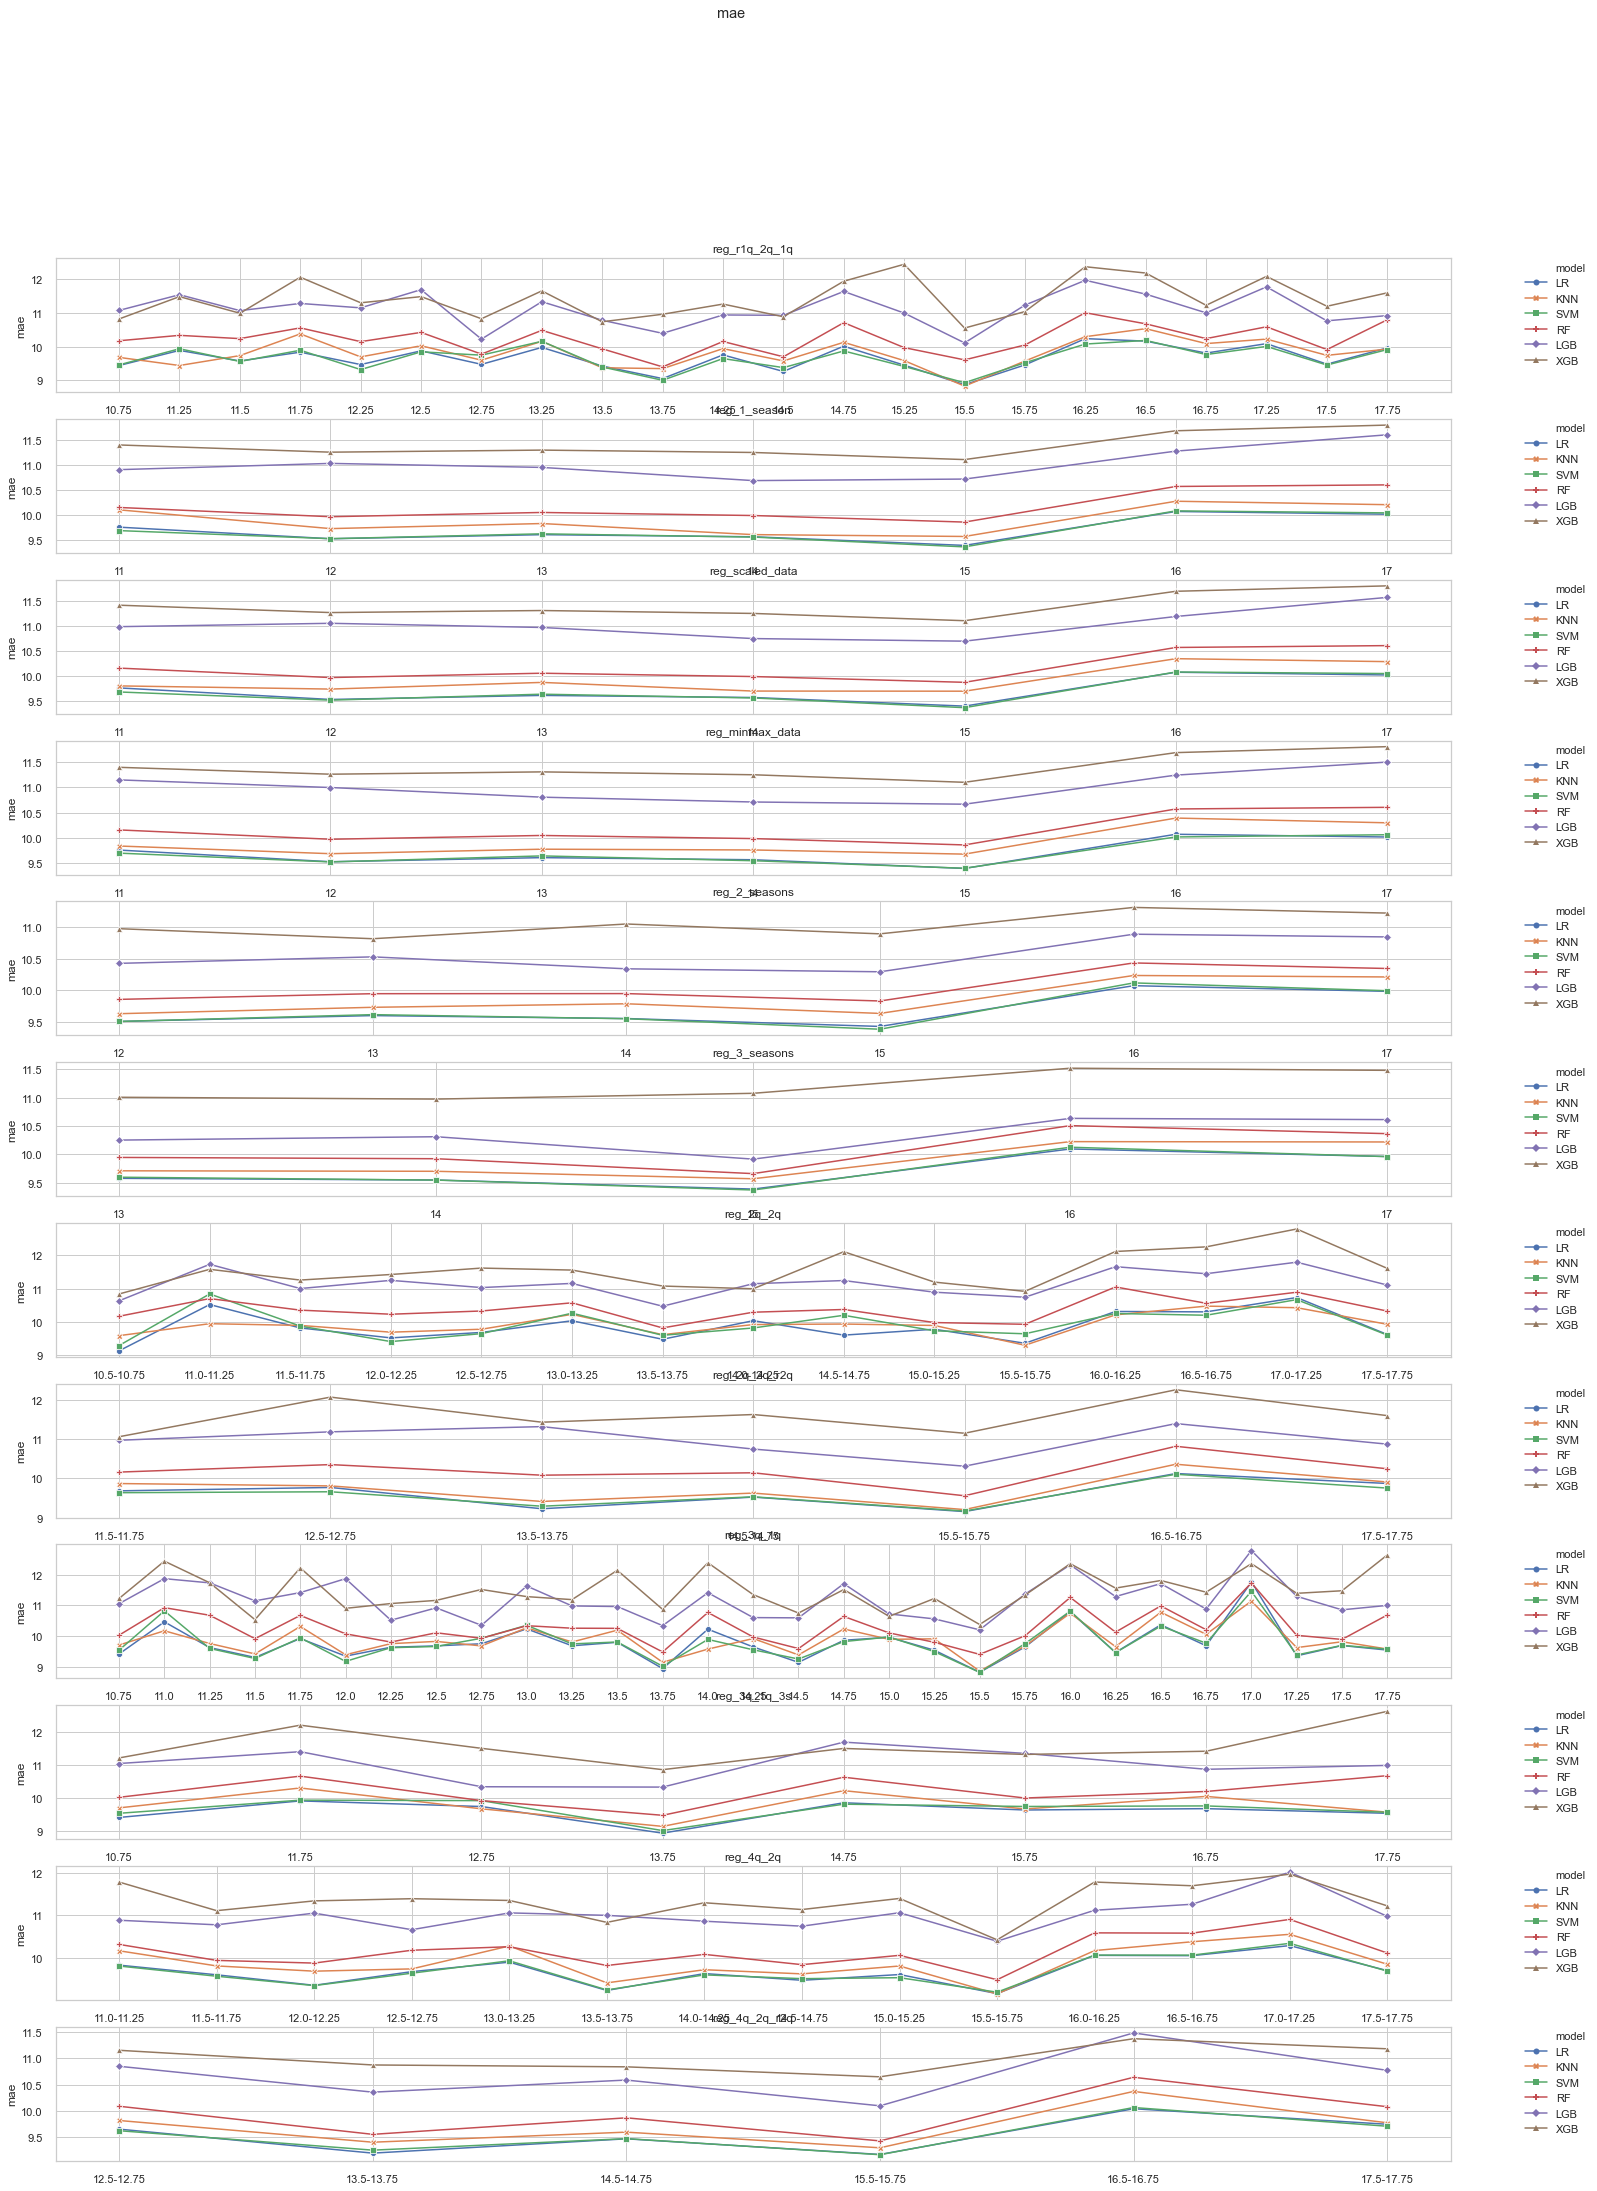

In [65]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

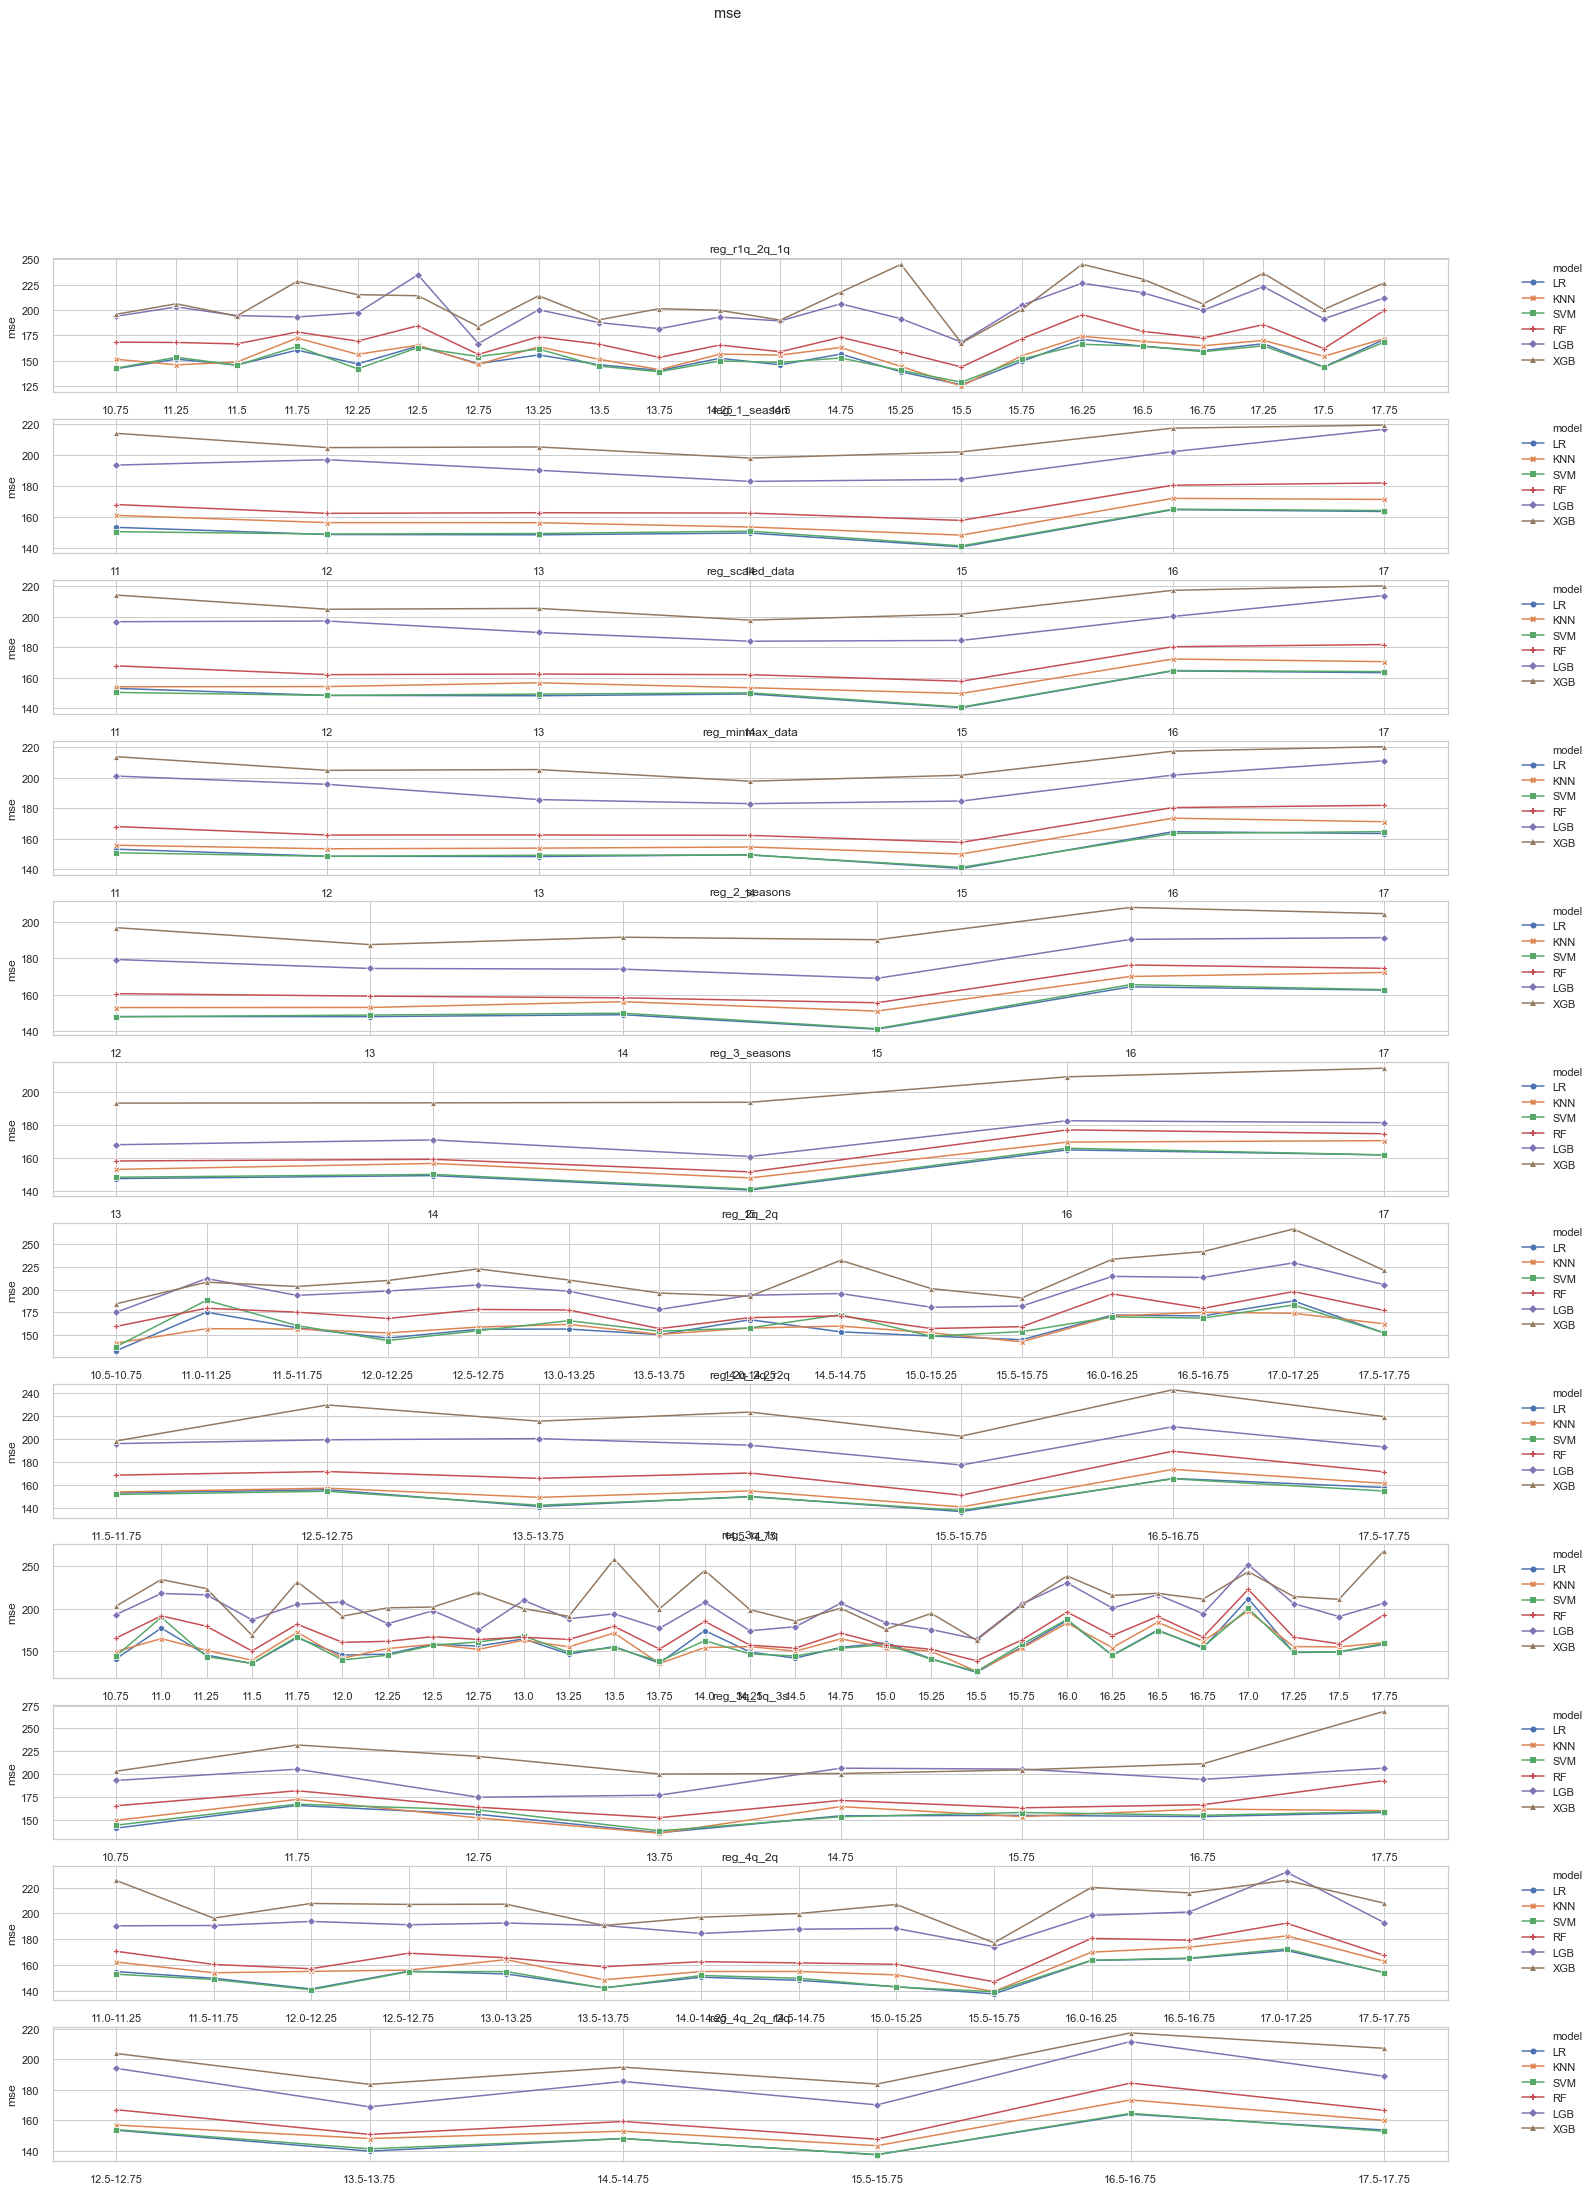

In [66]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

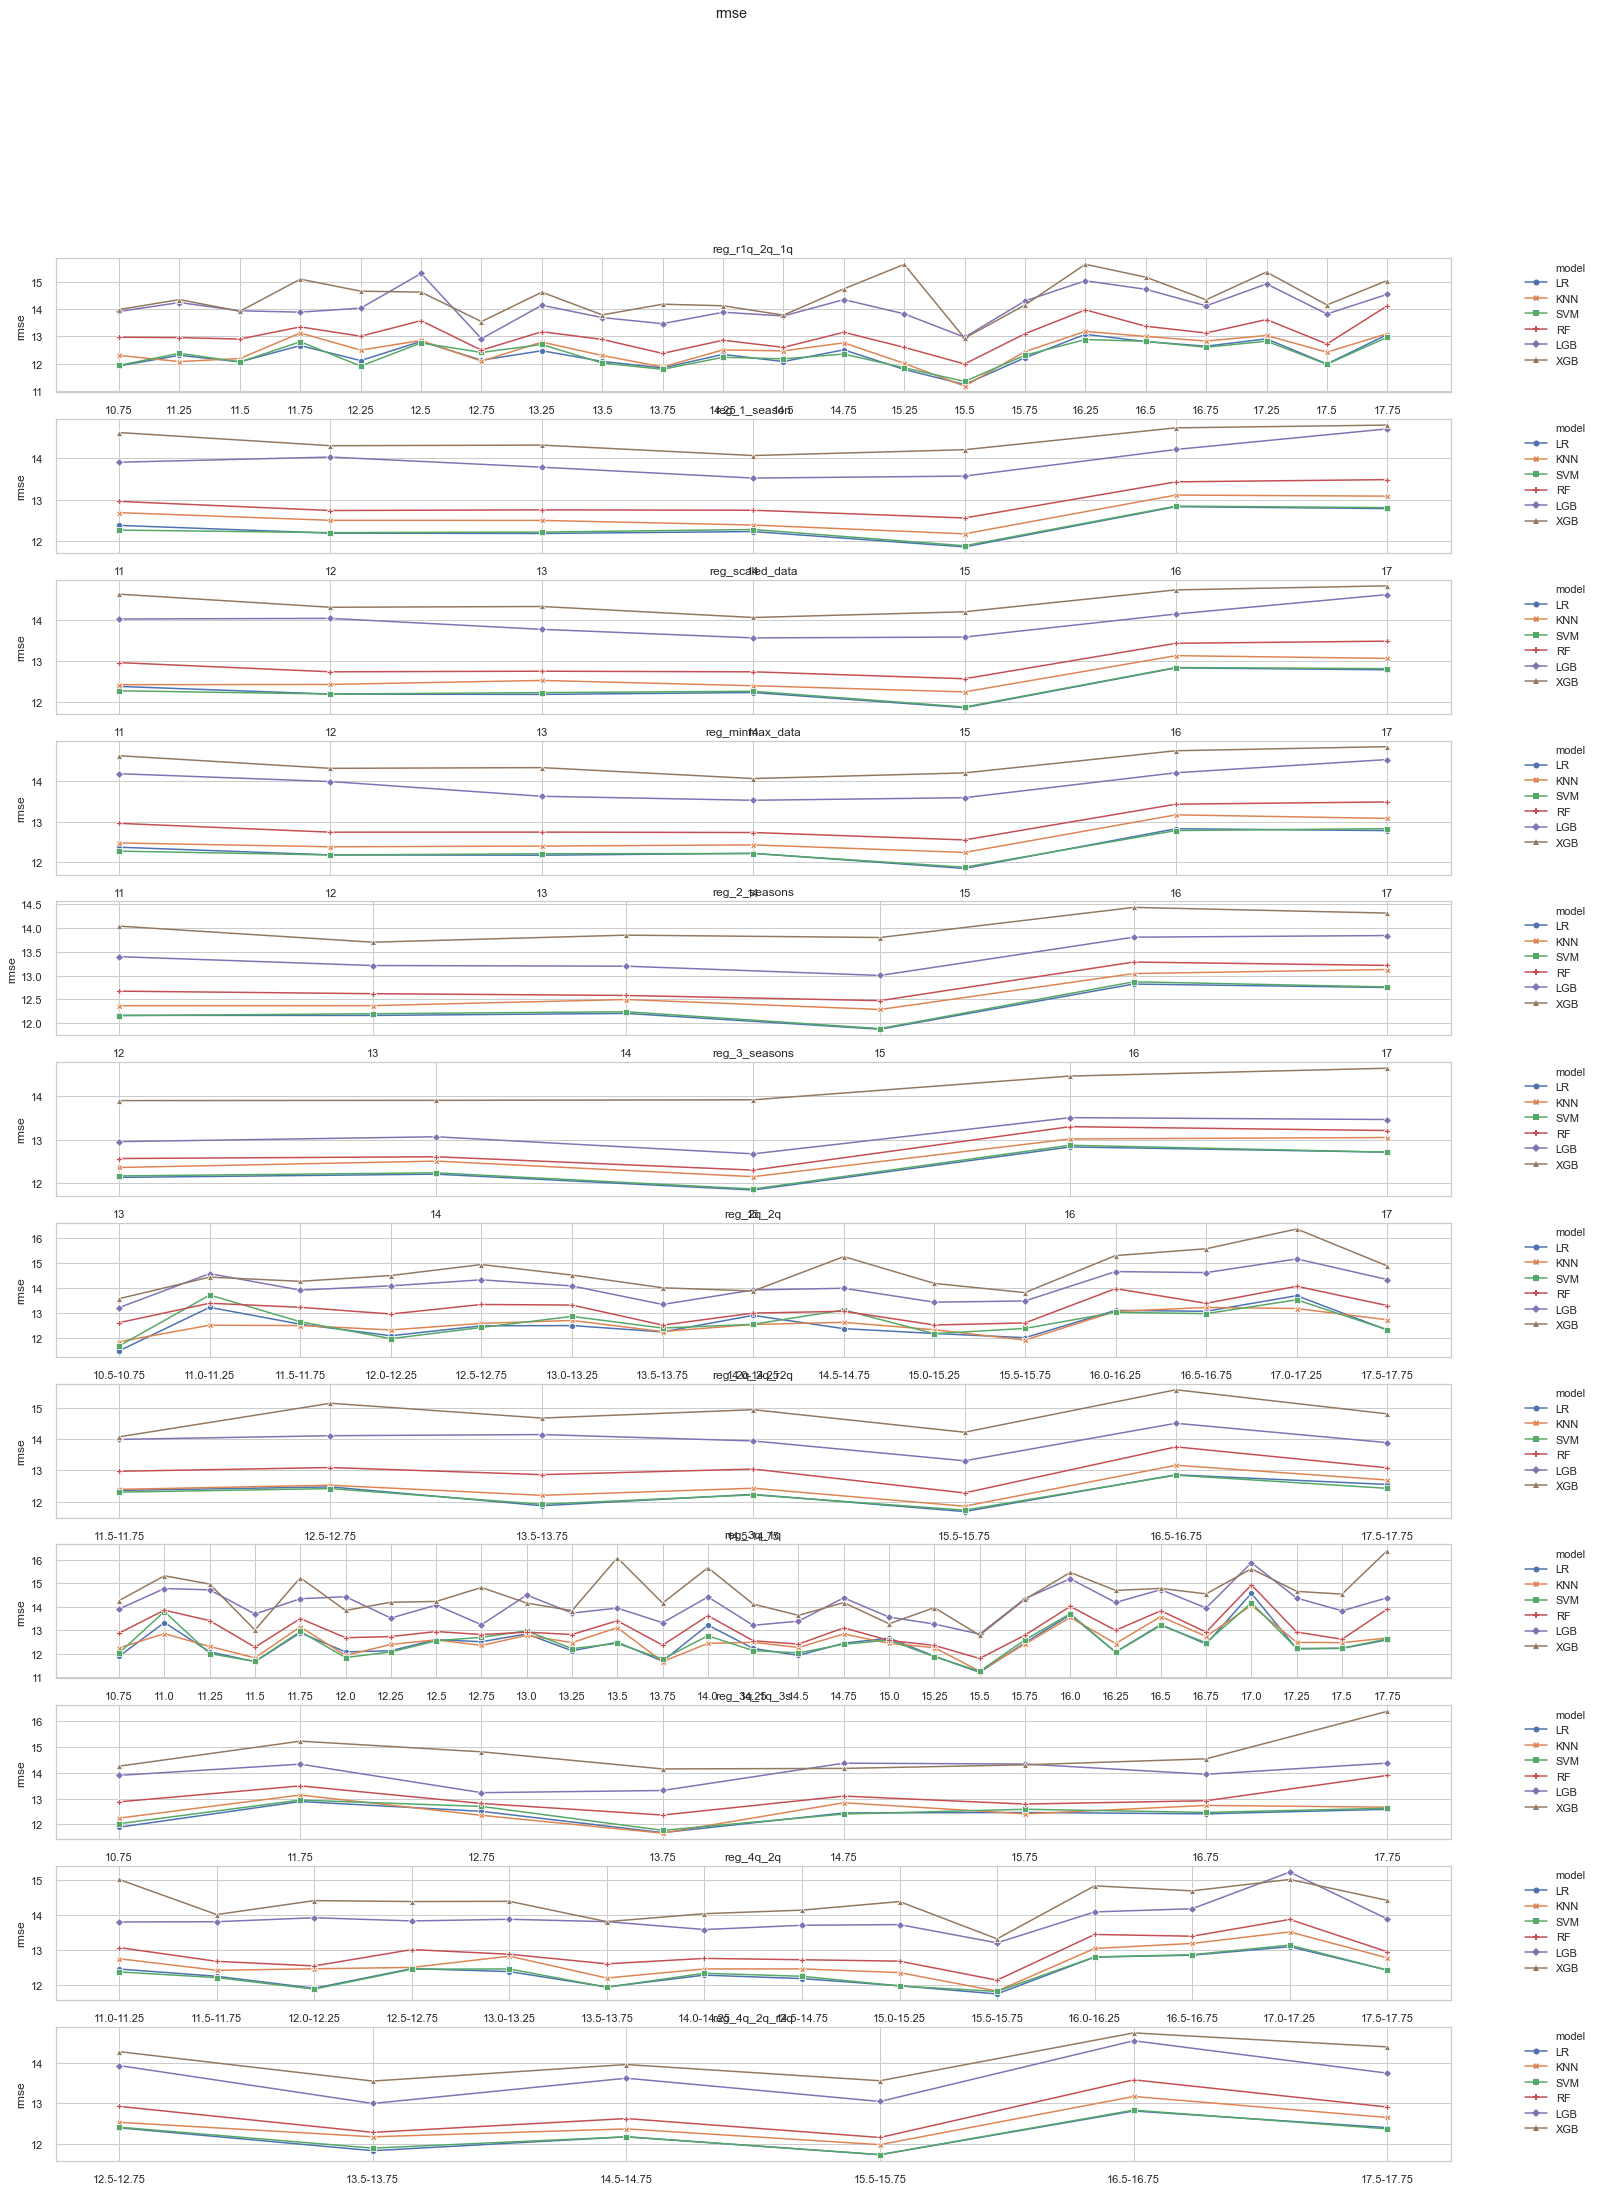

In [67]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)

### hyperparameter optimization

#### Imports

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hpsklearn import HyperoptEstimator
import hpsklearn
from hyperopt.pyll import scope, as_apply
from hyperopt import SparkTrials, STATUS_OK

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


#### Dataset

In [16]:
op_df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]

##### Seasons

In [17]:
op_df.SEASON.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

##### Clean Data

In [18]:
print(op_df.shape)
op_df = op_df.dropna()
print(op_df.isnull().sum().sum())
print(op_df.isna().sum().sum())
print(op_df.shape)

(9599, 261)
0
0
(9461, 261)


#### setup

In [19]:
exp_prefix = "reg_"
#exp_group_name = "clf_experiments"
exp_group_name = "reg_op"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

op_models = utils_exp.get_reg_models()

op_sscv = utils.SeasonSeriesSplit(op_df)
op_df_sscv = op_sscv.get_df()
op_X = op_df_sscv[exp_X_columns]
op_y = op_df_sscv[TARGET]



#### Utils

In [20]:
def walk_forward_val_mean_score(input_model):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test

        pipeline = Pipeline(steps=[
                ('model', input_model)])

        model = pipeline
        fit_info = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_results.append(mean_absolute_error(y_true, y_pred))

    return np.mean(metric_results)



#### Optimization

In [21]:
folds, train_seasons, test_seasons = op_sscv.split(train_size=2, test_size=1)

In [22]:
# name = 'reg'
# models =[
#     #hpsklearn.svc(name + '.SVM'),
#     #hpsklearn.random_forest(name + '.RF'),
#     #hpsklearn.xgboost_regression(name + '.XGB'),
#     #hpsklearn.lightgbm_regression(name + '.LGB')
#     hpsklearn.svc_linear(name + 'SVM')
# ]

# estim = HyperoptEstimator(regressor=hp.choice('%s' % name, models),
#                           preprocessing=None,
#                           algo=tpe.suggest,
#                           max_evals=500,
#                           trial_timeout=120)


# train_idx, test_idx = folds[-2]
# X_train, X_test = X.loc[train_idx], X.loc[test_idx]
# y_train, y_test = y.loc[train_idx], y.loc[test_idx]
# y_true = y_test

# estim.fit(X_train, y_train)
# print(estim.score(X_test, y_test))
# print(estim.best_model())

#### LightGBM

In [24]:
# 'objective': 'binary',
#     'metric': 'binary_logloss',
# #     'sub_feature': 0.5,
#     'min_data': 50,
#     'n_estimators': 500,
#     'metric': 'auc'

# objective='binary',
# metric='auc',

space = {
    'max_depth': hp.uniform('max_depth', 1, 11),
    'num_leaves': hp.uniform('num_leaves', 2, 121),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(100)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
    #boosting_type: hp.choice(name, ['gbdt', 'dart', 'goss'])
    'boosting_type': hp.choice('boosting_type', ['gbdt'])
}

default_hiperparameters = {
    'objective': 'binary',
    #'random_state': 0
}

def objective(space):
    print(space)
    hiperparameters = {**default_hiperparameters, **space}
    hiperparameters['max_depth'] = int(hiperparameters['max_depth'])
    hiperparameters['num_leaves'] = int(hiperparameters['num_leaves'])
    hiperparameters['n_estimators'] = int(hiperparameters['n_estimators'])
    hiperparameters['min_child_weight'] = int(hiperparameters['min_child_weight'])
    model = lgb.LGBMRegressor(
        **hiperparameters
    )

    accuracy = walk_forward_val_mean_score(model)

    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()
spark_trials = SparkTrials()
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=200,
        trials=spark_trials,
        rstate=np.random.RandomState(seed=0),
        return_argmin=False
    )
best

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or the current total of Spark task slots (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


  1%|          | 2/200 [02:11<3:36:51, 65.72s/trial, best loss: -10.997595591186654]


Total Trials: 10: 2 succeeded, 8 failed, 0 cancelled.


KeyboardInterrupt: 

#### Experiment

In [91]:
lgbparams = {'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6708923954804659,
 'colsample_bytree': 0.6000110807769761,
 'gamma': 0.3506689603388255,
 'learning_rate': 4.812206492908419e-08,
 'max_depth': 3.7205211307390265,
 'min_child_weight': 17.191236445639678,
 'n_estimators': 1200.0,
 'num_leaves': 95.60966938610218,
 'reg_alpha': 0.030016928545628624,
 'reg_lambda': 3.283314946517291,
 'subsample': 0.6085661260416309}

op_model = [
#     ("RF", RandomForestClassifier(
#                                       criterion='gini',
#                                       n_estimators=200,
#                                       max_depth=18,
#                                       max_leaf_nodes = 24,
#                                       min_samples_leaf = 2,
#                                       min_samples_split = 3,
#                                       n_jobs=-1,
#                                       random_state=0))
    ("LGB", lgb.LGBMRegressor(
        **lgbparams
#                 boosting_type='goss', colsample_bytree=0.758794422460012,
#               learning_rate=0.0009853276762182032, max_delta_step=0,
#               max_depth=6, min_child_weight=47, n_estimators=4600, n_jobs=1,
#               num_leaves=113, objective='regression',
#               reg_alpha=0.34215270718724283, reg_lambda=3.676702330857159,
#               scale_pos_weight=1, seed=0, subsample=0.9582168858299254)
    ))
]

In [92]:
experiment_name = f"{exp_prefix}2_seasons_op"
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, op_model, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name[:-3], metric='mae', filter_val=op_model[0][0])
print_prettier_exp_results(experiment_name)


# 0	reg_2_seasons	LR	8.192009	0.136491	10.392967	0.148882
# 2	reg_2_seasons	SVM	8.313091	0.182380	10.599064	0.196440
# 3	reg_2_seasons	RF	8.345848	0.111711	10.585308	0.150436
# 4	reg_2_seasons	LGB	8.702064	0.201812	11.010843	0.223081
# 5	reg_2_seasons	XGB	9.194161	0.189745	11.583278	0.253444
# 1	reg_2_seasons	KNN	9.952810	0.230096	12.663717	0.3101

name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

Running experiment reg_2_seasons_op


LightGBMError: Parameter num_leaves should be of type int, got "95.60966938610218"

### Final validation

#### Dataset

In [221]:
fv_df = season_games[(season_games.SEASON >= 2016)]

##### Seasons

In [222]:
fv_df.SEASON.unique()

array([2016, 2017, 2018, 2019])

##### clean data

In [223]:
print(fv_df.shape)
fv_df = fv_df.dropna()
print(fv_df.isnull().sum().sum())
print(fv_df.isna().sum().sum())
print(fv_df.shape)

(4749, 261)
0
0
(4685, 261)


#### setup

In [224]:
exp_prefix = "reg_"
exp_group_name = "reg_final_validation"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

fv_models = utils_exp.get_reg_models()

fv_sscv = utils.SeasonSeriesSplit(fv_df)
fv_df_sscv = fv_sscv.get_df()
fv_X = fv_df_sscv[exp_X_columns]
fv_y = fv_df_sscv[TARGET]

#### experiment

In [225]:
experiment_name = f"{exp_prefix}2_seasons_fv"

In [226]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = fv_sscv.split(train_size=2, test_size=1)
params = (experiment_name, fv_models, folds, train_seasons, test_seasons, fv_X, fv_y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2_seasons_fv
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_2_seasons_fv,LR,8.126956,0.155930,10.451102,0.314840
2,reg_2_seasons_fv,SVM,8.335560,0.139586,10.753539,0.295023
3,reg_2_seasons_fv,RF,8.399878,0.096542,10.745538,0.285764
4,reg_2_seasons_fv,LGB,8.811712,0.092612,11.226358,0.256028
5,reg_2_seasons_fv,XGB,9.241210,0.283491,11.692705,0.454053
1,reg_2_seasons_fv,KNN,10.491738,0.021062,13.378785,0.096284


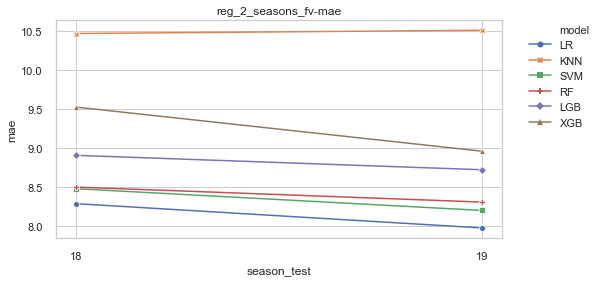

In [227]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))